In [1]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
%matplotlib inline
import pywt
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import dlib
from skimage.transform import pyramid_gaussian
from sklearn.externals import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
from skimage.feature import hog
import imutils
import glob

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
cwd = os.getcwd()
images = os.listdir(cwd+"/images/")
annotation = os.listdir(cwd+"/annotations/")

In [3]:
def data_extractor(root):
    file = []    
    def explore_element(element):
        file.append(element.tag)
        file.append(element.text)
        for child in element:
            explore_element(child)
        
    explore_element(root)
    return file

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    #Display result
    return (imArray_H)

def image_pipeline(image):
    #print(path+"/"+image)
    #img = cv2.imread(path+"/"+image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img, (5,5),2)
    edge = cv2.Canny(blur,5,100)
    retva = cv2.getGaborKernel((3,3), 10, 10,10,0)
    gab = cv2.filter2D(img,-1,retva)
    wvlt = w2d(img)
    wvlt = cv2.resize(wvlt, (gab.shape[1],gab.shape[0]), interpolation = cv2.INTER_AREA)
    a = edge*np.float32(gab)*np.float32(wvlt)
    #a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    a = np.array(a, dtype=np.uint8)
    return (a,img)

# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [4]:
labels = []
train_imgs_custom = []
hog_fd = []

orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2,2)
threshold = .3

org_imgs_copy = []
for i in range(len(annotation)):
    tree = ET.parse(cwd+"/annotations/"+annotation[i])
    root = tree.getroot()
    
    file = data_extractor(root)
    
    img_name = file[file.index('filename')+1]
    img = cv2.imread(cwd+"/images/"+img_name)
    
    a,img = image_pipeline(img)
    
    indices = [i for i, x in enumerate(file) if x == "name"]
    
    bbox = []
    for j in range(len(indices)):
        labels.append(file[indices[j]+1])
        xbox = int(file.index("xmin",indices[j]))
        for i in range(1,9,2):
            bbox.append(int(file[xbox+i]))
        
        #get original image
        org_img = img[bbox[1]:bbox[3],bbox[0]:bbox[2]]
        org_img = cv2.resize(org_img,(128,128))
        org_imgs_copy.append(org_img)
        
        #get hog features
        fd = hog(org_img, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
        hog_fd.append(fd)
        
        #get custom features
        crop = a[bbox[1]:bbox[3],bbox[0]:bbox[2]]
        crop = cv2.resize(crop,(128,128))
        train_imgs_custom.append(crop)
        
        #get background (-ve samples)
        bg_img = a[0:bbox[1],0:bbox[0]]
        bg_img = cv2.resize(bg_img,(128,128))
        train_imgs_custom.append(bg_img)
        
        bg_fd = hog(bg_img, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
        hog_fd.append(bg_fd)
        
        labels.append("bg")
        plt.imsave(str(annotation[i])+labels[j]+".png",a[bbox[1]:bbox[3],bbox[0]:bbox[2]])
        
train_imgs_custom = np.array(train_imgs_custom)
hog_fd = np.array(hog_fd)

In [6]:
print(labels)


['bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'crack', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'crack', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'crack', 'bg', 'crack', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullse

In [13]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
enc_label = le.fit_transform(labels)  

#add unique keys for backtracking one-hot encoded labels
decode = {}
unique_labels = (list(set(labels)))
enc_vec = np.zeros((len(labels)))

for j in range(len(unique_labels)):
    for i in range(len(labels)):
        if labels[i] == (unique_labels[j]):
            enc_vec[i] = j

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hog_fd, enc_vec, test_size = 0.20)

#for custom feature classifier
'''print(X_train.shape)
X_train = X_train.reshape(np.array(X_train).shape[0],-1)
print(X_train.shape)
X_test = X_test.reshape(np.array(X_test).shape[0], -1)'''

'print(X_train.shape)\nX_train = X_train.reshape(np.array(X_train).shape[0],-1)\nprint(X_train.shape)\nX_test = X_test.reshape(np.array(X_test).shape[0], -1)'

In [8]:
print(decode)
print(labels)
print(enc_label)
print(unique_labels)

{}
['bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'crack', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'crack', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'crack', 'bg', 'crack', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'crack', 'bg', 'bullseye', 'bg', 'bullseye', 'bg', 'scratch', 'bg', 'bullseye', 'bg', 'bul

## Model

In [9]:
shape = X_train[0].shape
for i in range(len(X_train)):
    if X_train[i].shape != shape:
        print(i)
print(X_train[0].shape)
print(X_train[:,].shape)

(8100,)
(123, 8100)


In [14]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

svc = LinearSVC(C=9)
svclassifier = SVC(kernel='linear',C=9)
knn = KNeighborsClassifier(n_neighbors=3)

svclassifier.fit(X_train, y_train)
svc.fit(X_train,y_train)
knn.fit(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [15]:
y_pred_svc = svclassifier.predict(X_test)
y_pred_lin = svc.predict(X_test)
y_pred_knn = knn.predict(X_test)
#plt.imshow(X_test[3].reshape(128,128))

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred_svc))
print(classification_report(y_test,y_pred_svc))

print("=================LINEAR======================")
print(confusion_matrix(y_test,y_pred_lin))
print(classification_report(y_test,y_pred_lin))

print("=================kNN======================")
print(confusion_matrix(y_test,y_pred_knn))
print(classification_report(y_test,y_pred_knn))

[[16  0  0  0]
 [ 0  2  5  0]
 [ 0  1  5  0]
 [ 0  0  1  1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       0.67      0.29      0.40         7
         2.0       0.45      0.83      0.59         6
         3.0       1.00      0.50      0.67         2

    accuracy                           0.77        31
   macro avg       0.78      0.65      0.66        31
weighted avg       0.82      0.77      0.76        31

=================LINEAR======================
[[16  0  0  0]
 [ 0  6  1  0]
 [ 0  2  4  0]
 [ 0  0  1  1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       0.75      0.86      0.80         7
         2.0       0.67      0.67      0.67         6
         3.0       1.00      0.50      0.67         2

    accuracy                           0.87        31
   macro avg       0.85      0.76      0.78        31
weighted avg     

## Metrics

[[16  0  0  0]
 [ 0  2  5  0]
 [ 0  1  5  0]
 [ 0  0  1  1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       0.67      0.29      0.40         7
         2.0       0.45      0.83      0.59         6
         3.0       1.00      0.50      0.67         2

    accuracy                           0.77        31
   macro avg       0.78      0.65      0.66        31
weighted avg       0.82      0.77      0.76        31

=================LINEAR======================
[[16  0  0  0]
 [ 0  6  1  0]
 [ 0  2  4  0]
 [ 0  0  1  1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       0.75      0.86      0.80         7
         2.0       0.67      0.67      0.67         6
         3.0       1.00      0.50      0.67         2

    accuracy                           0.87        31
   macro avg       0.85      0.76      0.78        31
weighted avg       0.88      0.87      0.87        31

=================kNN======================
[[16  0  0  0]
 [ 1  4  2  0]
 [ 2  1  3  0]
 [ 1  0  0  1]]
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        16
         1.0       0.80      0.57      0.67         7
         2.0       0.60      0.50      0.55         6
         3.0       1.00      0.50      0.67         2

    accuracy                           0.77        31
   macro avg       0.80      0.64      0.69        31
weighted avg       0.77      0.77      0.76        31



In [17]:
classifier_save_name = 'hog_svc_classifier.npy'
joblib.dump(svc, classifier_save_name)

['hog_svc_classifier.npy']

## Inference

In [18]:
# Upload the saved svm model:
model = joblib.load(cwd+"/"+classifier_save_name)

In [19]:
scale = 0
detections = []
# read the image you want to detect the object in:
img= cv2.imread(cwd+"/images/"+"11.jpg")
#img = cv2.resize(img, (300,300))
# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (128,128)
windowSize=(winW,winH)
downscale=1.5

win = []
resz = []

0


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


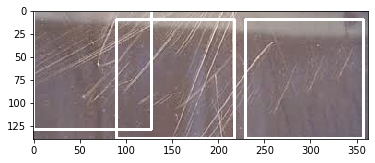

In [21]:
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from sklearn.externals import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2
import os
import glob

#Define HOG Parameters
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

# define the sliding window:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

# Upload the saved svm model:
model = joblib.load('hog_svclassifier.npy')

# Test the trained classifier on an image below!
scale = 0
detections = []
# read the image you want to detect the object in:
img= cv2.imread("/home/arjun/Desktop/iotrics/test/2.jpeg")

# Try it with image resized if the image is too big
#img= cv2.resize(img,(128,128)) # can change the size to default by commenting this code out our put in a random number

# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (128,128)
windowSize=(winW,winH)
downscale=1.5
# Apply sliding window:
for resized in pyramid_gaussian(img, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=10, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        window=color.rgb2gray(window)
        fds = hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2')  # extract HOG features from the window captured
        fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if np.average(model.decision_function(fds)) > 0.5:
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)),
                                   pred,
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
clone = resized.copy()

detections = sorted(detections,key=lambda detections:detections[2])

rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
#print("detection class: ", sc)

np_detect = np.array(detections)
ind = []
#print(np.min(np.where(np_detect[:,2]==3)))
for i in range(0,4,1):
    try:
        ind.append(np.min(np.where(np_detect[:,2]==i)))
    except ValueError:
        break
        
    
for i in range(len(ind)-1):
    pick = non_max_suppression(rects[ind[i]:ind[i+1]], overlapThresh = 0.3)
    
    print(i)
    if i == 1 :
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(img, (xA, yA), (xB, yB), (255,0,0), 2)
    if i  == 2 :
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(img, (xA, yA), (xB, yB), (0,0,255), 2)
    if i == 3 :
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(img, (xA, yA), (xB, yB), (0,255,255), 2)
    if i == 0 :
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(img, (xA, yA), (xB, yB), (255,255,255), 2)
            
plt.imshow(img)

## Results

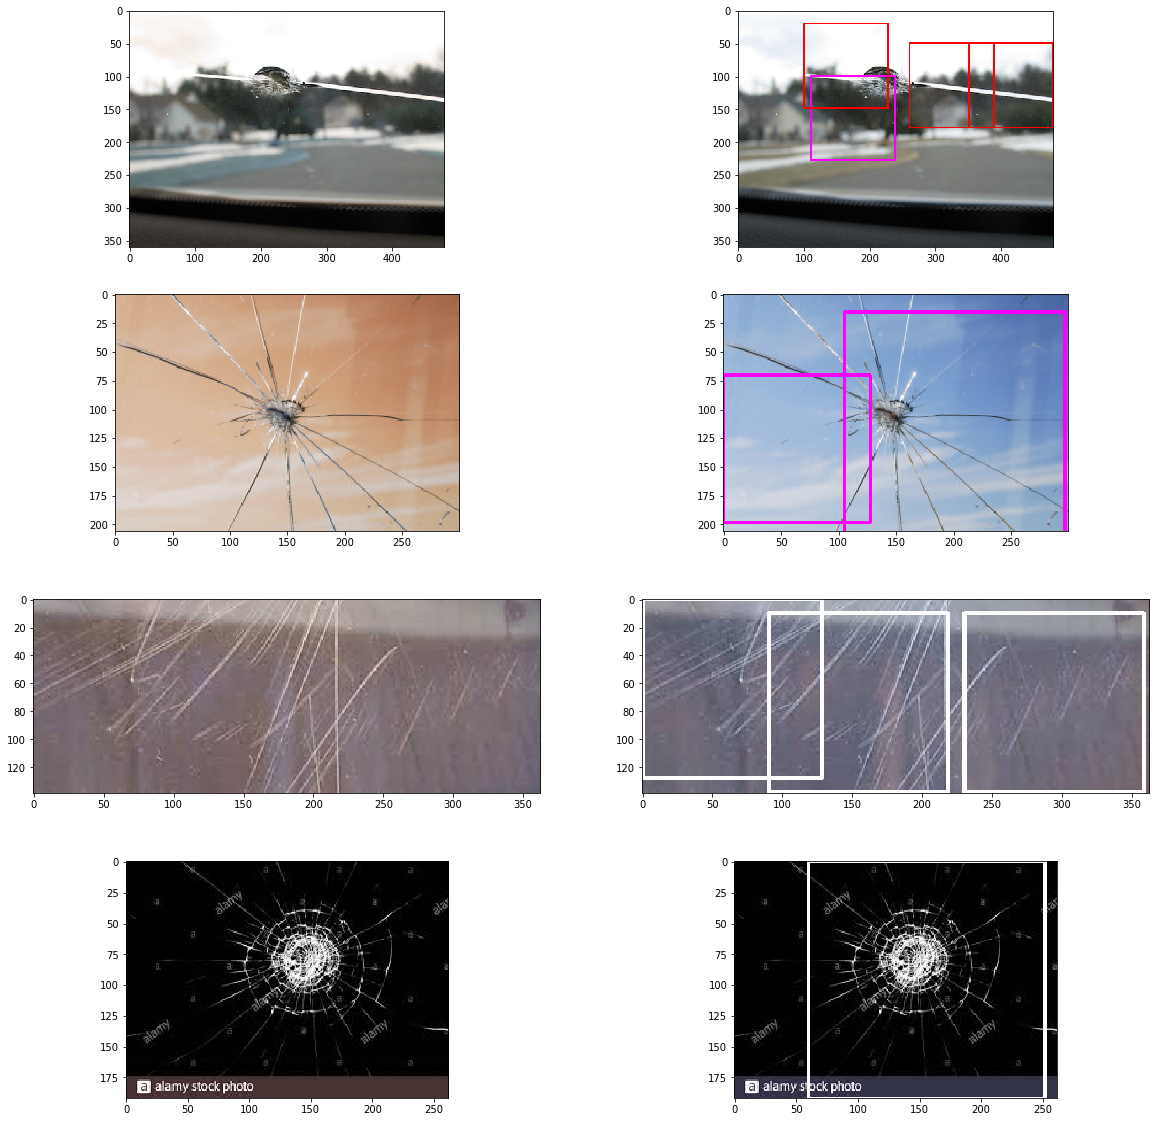

In [393]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 4

img = cv2.imread("images/15.jpg")
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
img = cv2.imread("ex1.png")
fig.add_subplot(rows, columns, 2)
plt.imshow(img)

img = cv2.imread("images/50.jpg")
fig.add_subplot(rows, columns, 3)
plt.imshow(img)
img = cv2.imread("ex2.png")
fig.add_subplot(rows, columns, 4)
plt.imshow(img)

img = cv2.imread("test/2.jpeg")
fig.add_subplot(rows, columns, 5)
plt.imshow(img)
img = cv2.imread("ex5.png")
fig.add_subplot(rows, columns, 6)
plt.imshow(img)

img = cv2.imread("test/1.jpeg")
fig.add_subplot(rows, columns, 7)
plt.imshow(img)
img = cv2.imread("ex4.png")
fig.add_subplot(rows, columns, 8)
plt.imshow(img)


plt.show()